# Descriptive Text Mining

Programmazione di Applicazioni Data Intensive \
Laurea in Ingegneria e Scienze Informatiche  \
DISI - Università di Bologna, Cesena

Obiettivo: dai rapporti testuali redatti da National Transportation Safety Board che descrivono le cause di incidenti aerei, individuare, mediante analisi semantica con LSA, le cause che contribuiscono a provocare incidenti destroyed.

## Librerie impiegate

In [100]:
!pip install spacy -U
!python -m spacy download en_core_web_sm

     |████████████████████████████████| 13.9 MB 6.0 MB/s            
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [101]:
from os import path, makedirs
from tabulate import tabulate
from urllib.request import urlretrieve
import numpy as np
from numpy.linalg import norm
import pandas as pd
import spacy

from matplotlib import pyplot as plt
from matplotlib.colors import from_levels_and_colors
import plotly.graph_objects as go
import plotly.express as px

from scipy.sparse import csr_matrix
from scipy.stats import chi2_contingency

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils.extmath import randomized_svd
from sklearn.metrics.pairwise import cosine_similarity

In [102]:
images_path = "./"
makedirs(images_path, exist_ok = True)
get_path = lambda fname, format : path.join(images_path, fname + "." + format)
savefig = lambda fname, format : plt.savefig(get_path(fname, format), format = format)

## Funzioni impiegate

In [103]:
def makequery(qterms, tdm, U, s, vocabulary):
    query = np.zeros(tdm.shape[0])

    # one hot query
    query[[vocabulary.get(term) for term in qterms]] = 1
    # weighted query
    wquery = np.log(query + 1) * (1 - entropy(tdm, axis = 1))
    # folded query
    qls = np.matmul(wquery.T, U)

    # cosine similary query term
    dk = np.matmul(qls, np.diag(np.power(s, -1)))
    dksrs = np.matmul(dk, np.diag(np.sqrt(s)))

    return qterms, query, wquery, qls, dk, dksrs

In [104]:
def get_matching_docs(a, b):
    a = np.asarray(a)
    b = np.asarray(b)
    return np.isin(a, b).sum()

In [105]:
def entropy(m, axis = 0):
    m = np.asarray(m)
    p = 1.0 * m / np.sum(m, axis = axis, keepdims = True)
    ndocs = m.shape[axis]
    vec = (p * np.log(p, out = np.zeros_like(p), where = (p!=0))) / np.log(ndocs)
    entropy = - np.sum(vec, axis = axis)
    return entropy

In [106]:
def get_word_counts(m, col_mask, row_mask):
    # get only doc_class related docs
    sliced = tdm[:, col_mask]
    
    # slice rows, get only columns with at least one of 
    # the entries in the row mask.
    sliced = sliced[row_mask, :]
    
    with_word = get_occ_word_all_docs(sliced)
    total = col_mask.sum()
    without_word = total - with_word
    return with_word, without_word

def get_occ_word_all_docs(sliced):
    # logical AND applied to all rows, one for each term
    # in the list.
    rows = [row for row in sliced]
    tmp = np.asarray(sliced[0])
    for row in rows:
        b = np.logical_and(tmp, row)
        tmp = b
    b = np.asarray(b)[0]
    return b.sum()

In [179]:
def term_analysis(
    terms,
    doc_classes,
    without_word_in,
    with_word_in,
    without_word_out,
    with_word_out,
    quiet=False):  
    
    get_term_doc_df = \
        lambda data, terms, doc_classes : pd.DataFrame(
            data,
            index = [f"not {terms}", f"{terms}"], 
            columns = [f"not {doc_classes}", f"{doc_classes}"]
        )   
    
    terms = "_".join(terms)
    doc_classes = "_".join(doc_classes)
    
    observed = [
        [without_word_out, without_word_in],
        [with_word_out, with_word_in]
    ]
    observed = get_term_doc_df(observed, terms, doc_classes)

    chi2, p, ddof, expected = chi2_contingency(
        observed,
        correction = False
    )
    expected = get_term_doc_df(expected, terms, doc_classes)
    
    if quiet is False:
        print(f"Pearson's Chi-squared test with {ddof} ddof")
        print("--------------------------------------\n")
        print("Observed frequencies") 
        print(tabulate(observed, headers='keys', tablefmt='psql'))
        print("\nExpected frequencies")
        print(tabulate(expected, headers='keys', tablefmt='psql'))
        print(f"\nX-squared: \t{chi2}")
        print(f"p-value \t{p}")
    
    return chi2, p

In [108]:
def get_similar(m, q, docs, threshold = 0, topn = 10):
    if threshold >= 1.0 or threshold < 0:
        raise("Threshold must be in (0,1]")
    
    docs = np.asarray(docs)
    docs = docs.reshape(docs.shape[0], 1)
    q = np.asarray(q)
    q = q.reshape(1, m.shape[1])
    query2doc = cosine_similarity(q, m)
    query2doc = query2doc.T
    
    mask = query2doc > threshold
    query2doc_masked = query2doc[mask]
    docs_masked = docs[mask]

    docs_idx = [idx for idx, elem in enumerate(mask) if elem == 1]

    # use a structured array
    dtype = [("id", int), ("doc", docs.dtype), ("sim_val", float)]
    ranks = [(z, y, x) for x, y, z in zip(query2doc_masked, docs_masked, docs_idx)]
    ranks = np.array(ranks, dtype = dtype)
    ranks = np.sort(ranks, order = "sim_val")
    ranks = ranks[::-1]  # docs in decreasing order
    
    nranks = len(ranks)
    if topn < nranks:
        ranks = ranks[:topn] # show only first top n matches
    return list(ranks)

In [109]:
def plot_lsa2D(x, y, terms=None):
    fig = go.Figure()

    if terms is None:
        trace = go.Scatter(
            x=x,
            y=y,
            mode="markers+text",
            name="Markers and Text")
    else:
        trace = go.Scatter(
                    x=x,
                    y=y,
                    mode="markers+text",
                    name="Markers and Text",
                    text=terms,

                    textposition="bottom center",
                    textfont=dict(
                        family="sans serif",
                        size=9))

    fig.add_trace(trace)
    fig.update_layout(
        height=800,
        template = "none"
    )
    fig.update_traces(marker=dict(size=3,))
    return fig

In [110]:
def plot_knee_points(s):
    xlen = 20
    fordiff = lambda x : x[1:len(x)] - x[0:(len(x) - 1)]
    skd = fordiff(s)
    skdd = fordiff(skd)
    skcurv = skdd[0:xlen] / np.power(1 + np.power(skd[0:xlen], 2), 1.5)
    
    plt.figure(figsize=(12, 8))
    plt.plot(np.linspace(1, xlen, xlen), skcurv, "k.-")
    return plt

In [111]:
def plot_lsa2D_termdoc(
    classes,
    d1,
    d2,
    t1,
    t2,
    ord_terms):
    
    dfc = pd.DataFrame(
        {"Incident" : classes,
         "lsa1" : d1,
         "lsa2" : d2}
    )

    fig = plot_lsa2D(t1, t2, ord_terms)

    fig1 = px.scatter(
        dfc,
        x = "lsa1",
        y = "lsa2",
        color="Incident",
        color_discrete_map=
        {"None": "lightgrey",
         "Minor" : "green",
         "Substantial": "orange",
         "Destroyed": "black"},
        template = "none",
        height = 800
    )

    fig.update_traces(name = "Termini", marker_color="blue")
    fig = go.Figure(data = fig1.data + fig.data)
    fig.update_traces(marker=dict(size=3,))
    fig.update_layout(
        height=800,
        template = "none"
    )
    fig.update_traces(marker=dict(size=3,))
    
    return fig

In [180]:
def chisquare_lsa(
    qclasses,
    qterms,
    query_matching_idxs,
    classes,
    dls_rows,
    quiet=False):
    
    doc_classes = ["Negative"]
    terms = ["roma", "gemelli"]
    destroyed_idx = np.asarray(classes == qclasses[0])
    doc_mask = destroyed_idx != 0

    query_mask = np.zeros(dls_rows)
    query_mask[query_matching_idxs] = 1

    mask = np.logical_and(doc_mask, query_mask)
    total = doc_mask.sum()
    with_word_in = mask.sum()
    without_word_in = total - with_word_in

    doc_mask = ~doc_mask
    mask = np.logical_and(doc_mask, query_mask)
    total = doc_mask.sum()
    with_word_out = mask.sum()
    without_word_out = total - with_word_out

    return term_analysis(
        qterms,
        qclasses,
        without_word_in,
        with_word_in,
        without_word_out,
        with_word_out,
        quiet=quiet
    )

In [113]:
def get_query_result(
    docs,
    ord_terms,
    dls,
    tls,
    qls,
    tlsn,
    r=482,
    low=0.2,
    high=0.85):
    
    # get matching docs
    docs_ranked = get_similar(
        dls,
        qls,
        docs,
        threshold = low,
        topn = r
    )
    
    # get matching terms
    terms_ranked = get_similar(
        tls[:,0:6],
        qls[0:6],
        ord_terms,
        threshold = low,
        topn = r
    )
    terms_ranked = [rank for rank in terms_ranked if rank[2] > high]
    sim_scores_reduced_idx = [rank[0] for rank in terms_ranked]
    norms = tlsn[sim_scores_reduced_idx]
    
    return docs_ranked, terms_ranked, norms

## Caricamento dei dati

In [114]:
import sys
IN_COLAB = 'google.colab' in sys.modules

In [115]:
dataset_url = "https://raw.githubusercontent.com/Da3dalu2/thesis-notebooks/main/data/ntsb_causes.csv"
dataset_name = "ntsb_causes.csv"
if IN_COLAB:
    data_path = "./"
else:
    plt.style.use('science')
    data_path = "../data/"

if not path.exists(data_path + dataset_name):
    urlretrieve(dataset_url, dataset_name)

df = pd.read_csv(
        data_path + dataset_name, 
        dtype={"damage_class" : "category", "narr_cause" : "string"}
)  

In [116]:
damage_class = list(df.damage_class.unique())

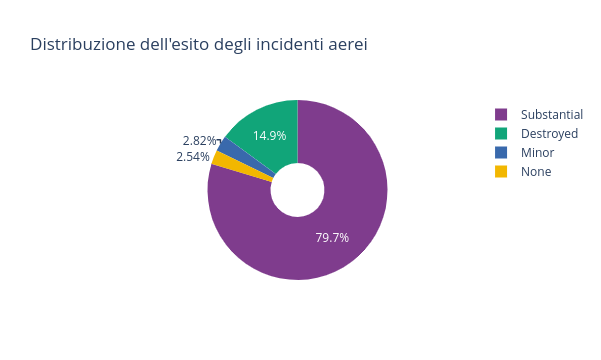

In [117]:
fig = go.Figure(
    data = [go.Pie(labels = damage_class,
            values = df.damage_class.value_counts(),
            marker = dict(colors = px.colors.qualitative.Bold),
            hole = .3)]
)

fig.update_layout(title = "Distribuzione dell'esito degli incidenti aerei")
fig.show()

## Costruzione della matrice termini documenti

In [118]:
excluded = [
#     "tok2vec",
#     "tagger",
#     "parser",
    "ner",
#     "attribute_ruler",
#     "lemmatizer"
]
nlp = spacy.load("en_core_web_sm", exclude=excluded)
# nlp.Defaults.stop_words |= {"effect", "effects"}

In [119]:
def spacy_tokenizer(sentence):
    sentence = nlp(sentence)
    tokens = [token.lemma_.lower() for token in sentence 
          if token.is_stop == False 
          and token.is_punct == False
          and len(token.text) > 2
          and token.is_ascii == True
          and token.is_alpha == True
          and token.is_quote == False
          and token.is_space == False
          and token.is_currency == False
          and token.like_email == False
          and token.like_num == False
          and token.like_url == False
         ]
    return tokens

In [120]:
df.columns

Index(['damage_class', 'narr_cause'], dtype='object')

In [121]:
min_df_one_percent = int(df.narr_cause.count() / 100)
min_df_one_percent

32

In [122]:
vect = CountVectorizer(
    strip_accents = "ascii",
    tokenizer = spacy_tokenizer,
    min_df = min_df_one_percent
)
dtm = vect.fit_transform(df.narr_cause)
tdm = dtm.transpose()

# adding a nonzero scalar to a sparse matrix is not supported
tdm = tdm.todense()

b = (1 - entropy(tdm, axis = 1))
b = np.array(b)

a = np.log(tdm + 1)
a = np.array(a)

wtdm = (a.T * b).T
wtdm = csr_matrix(wtdm)

In [123]:
dtm

<3229x201 sparse matrix of type '<class 'numpy.int64'>'
	with 35409 stored elements in Compressed Sparse Row format>

In [124]:
ord_terms = vect.get_feature_names()

In [125]:
vocabulary = vect.vocabulary_

In [126]:
dtm.astype(bool).mean()

0.05455688420702311

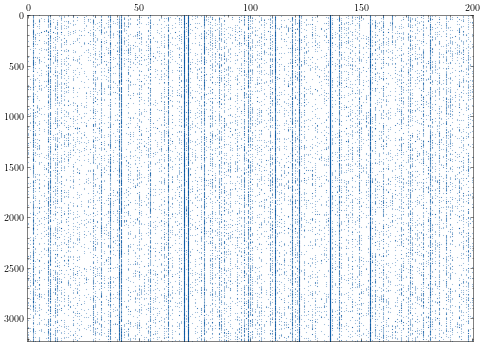

In [127]:
fig = plt.figure()
plt.spy(dtm, markersize=0.10, aspect = 'auto')
fig.set_size_inches(8,6)

## Analisi semantica latente

In [128]:
U, s, Vh = randomized_svd(wtdm, n_components = 69, random_state = 5)

In [129]:
s.shape

(69,)

In [130]:
U.shape

(201, 69)

In [131]:
Vh.shape

(69, 3229)

In [132]:
Vh = Vh.transpose()

In [133]:
Vh.shape

(3229, 69)

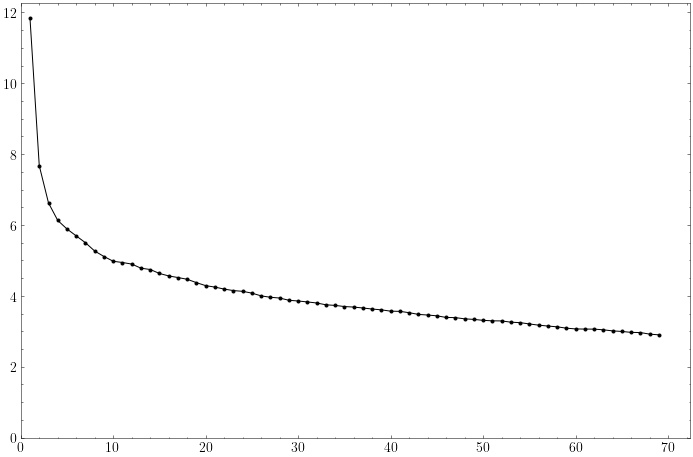

In [134]:
plt.figure(figsize=(12, 8))
plt.plot(np.linspace(1, 69, 69), s, "k.-")
plt.ylim(bottom=0)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(xmin=0)
savefig("power_law_svd", "pdf")

In [135]:
# U è chiamata tk (lsar$tk), S è sk (lsar$sk), V^t è dk (lsar$dk)
tls = np.matmul(U, np.diag(s))
dls = np.matmul(Vh, np.diag(s))

In [136]:
tls.shape

(201, 69)

In [137]:
dls.shape

(3229, 69)

## Visualizzazione dello spazio trasformato

Visualizzazione dei termini nelle prime due dimensioni latenti

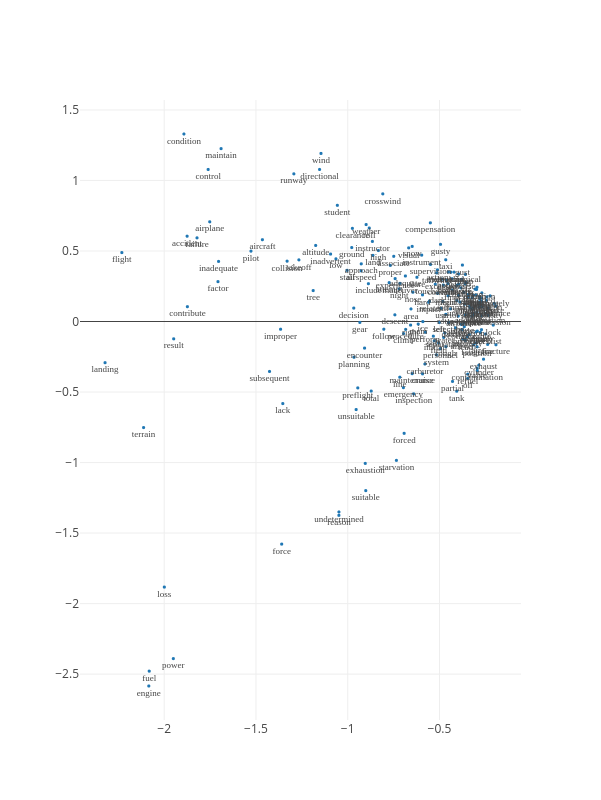

In [138]:
plot_lsa2D(-1*tls[:,0], -1*tls[:,1], ord_terms)

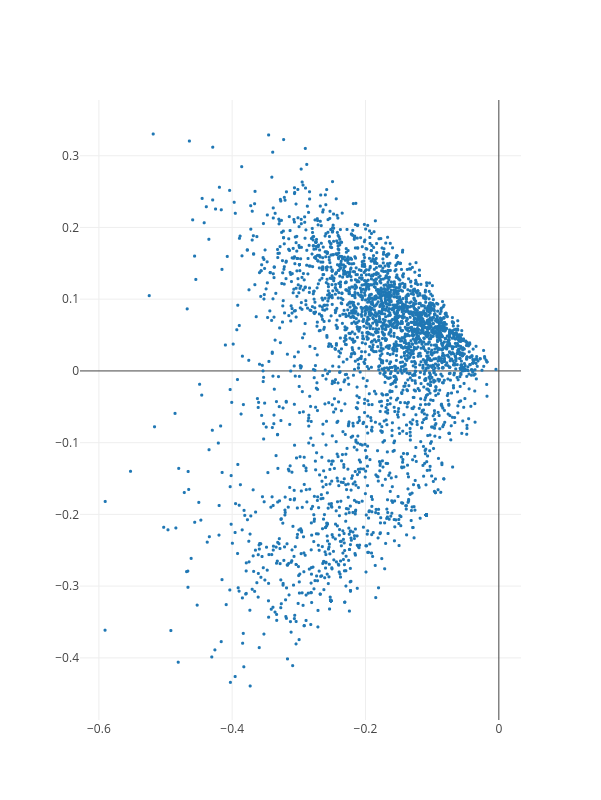

In [139]:
plot_lsa2D(-1*dls[:,0], -1*dls[:,1])

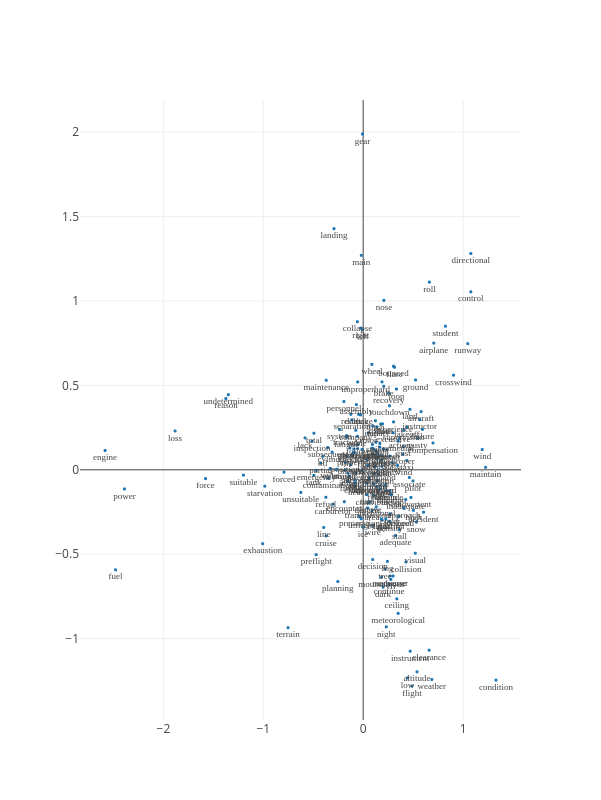

In [140]:
plot_lsa2D(-1*tls[:,1], tls[:,2], ord_terms)

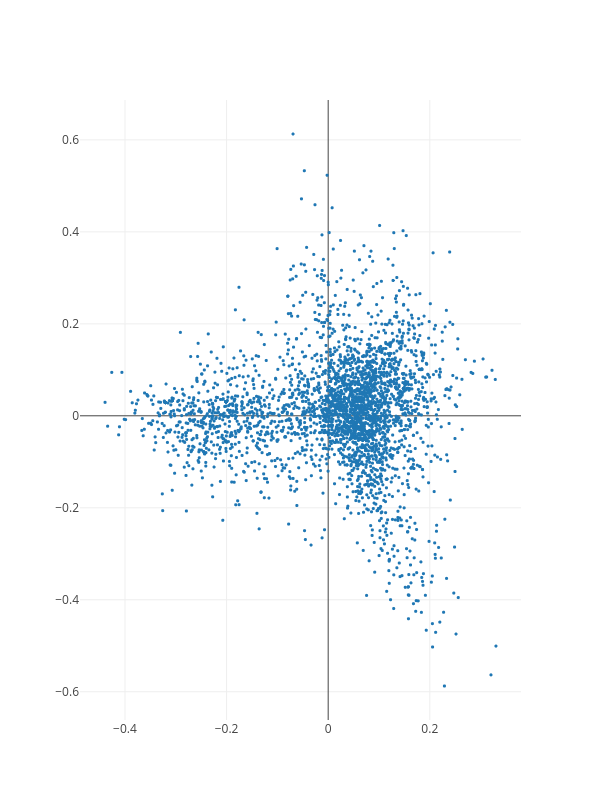

In [141]:
plot_lsa2D(-1*dls[:,1], dls[:,2])

## Distribuzione delle tipologie di incidenti

In [142]:
df.damage_class.value_counts()

Substantial    2574
Destroyed       482
None             91
Minor            82
Name: damage_class, dtype: int64

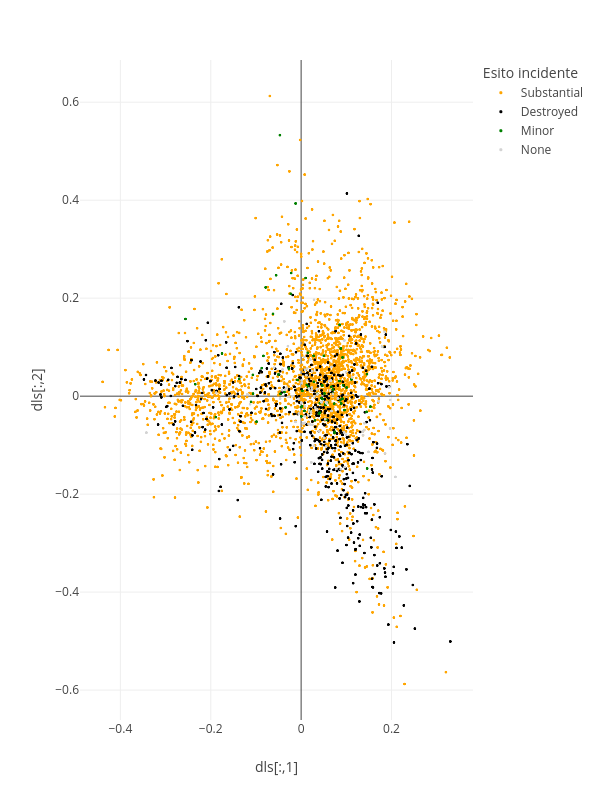

In [143]:
dfc = pd.DataFrame(
    {"Esito incidente" : df.damage_class,
     "dls[:,1]" : -1*dls[:,1],
     "dls[:,2]" : dls[:,2]}
)

fig = px.scatter(
    dfc,
    x="dls[:,1]",
    y="dls[:,2]",
    color="Esito incidente",
    color_discrete_map=
    {"None": "lightgrey",
     "Minor" : "green",
     "Substantial": "orange",
     "Destroyed": "black"},
    template="none",
    height=800
)
    
fig.update_traces(marker=dict(size=3,))
fig.show()

## Analisi termini e documenti

In [144]:
tlsn = norm(tls, 2, axis = 1)
dlsn = norm(dls, 2, axis = 1)
tlsn = tls / tlsn[:,None]
dlsn = dls / dlsn[:,None]

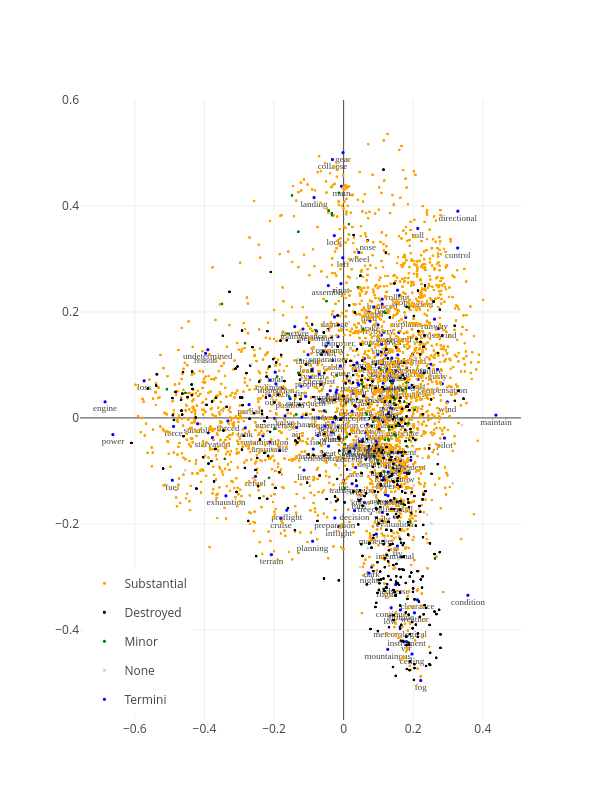

In [145]:
plot_lsa2D_termdoc(
    df["damage_class"],
    -1*dlsn[:,1],
    dlsn[:,2],
    -1*tlsn[:,1],
    tlsn[:,2],
    ord_terms
).update_layout(legend=dict(
    yanchor="bottom",
    y=0.01,
    xanchor="left",
    x=0.01
)).show()

## Analisi del termine weather

In [146]:
terms = ["weather"]
doc_classes = ["Destroyed"]

doc_idx = np.asarray(df.damage_class == doc_classes[0])
doc_mask = doc_idx != 0

term_idx = [vocabulary.get(term) for term in terms]
term_mask = np.zeros(tdm.shape[0], dtype = bool)
term_mask[term_idx] = True

with_word_in, without_word_in = get_word_counts(tdm, doc_mask, term_mask)

doc_mask = ~doc_mask

with_word_out, without_word_out = get_word_counts(tdm, doc_mask, term_mask)

term_analysis(
    terms,
    doc_classes,
    without_word_in,
    with_word_in,
    without_word_out,
    with_word_out
)

Pearson's Chi-squared test with 1 ddof
--------------------------------------

Observed frequencies
+-------------+-----------------+-------------+
|             |   not Destroyed |   Destroyed |
|-------------+-----------------+-------------|
| not weather |            2664 |         428 |
| weather     |              83 |          54 |
+-------------+-----------------+-------------+

Expected frequencies
+-------------+-----------------+-------------+
|             |   not Destroyed |   Destroyed |
|-------------+-----------------+-------------|
| not weather |         2630.45 |    461.55   |
| weather     |          116.55 |     20.4503 |
+-------------+-----------------+-------------+

X-squared: 	67.56407215908636
p-value 	2.0395037376620448e-16


## Costruzione di un'interrogazione semplice

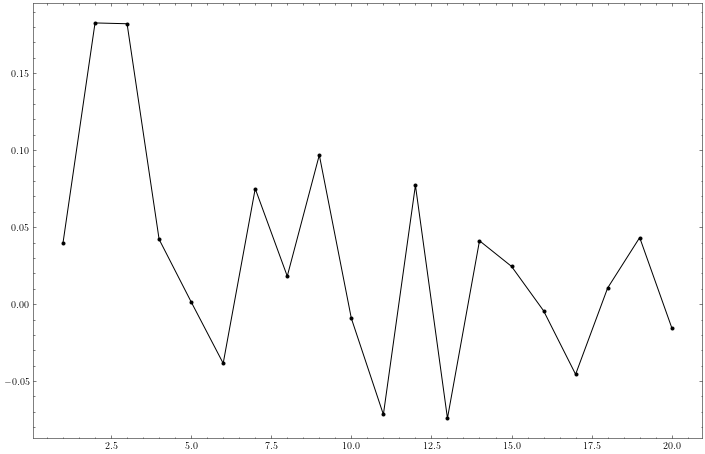

In [147]:
plot_knee_points(s);

In [148]:
knee = 6
qterms = ["adverse", "weather"]
_, _, _, qls, _, _ = makequery(qterms, tdm, U, s, vocabulary);
qlsn = norm(qls, 2)
qlsn = qls / qlsn

m = dls[:,0:knee]
q = qls[0:knee]
docs = df.narr_cause

ranks = get_similar(
    m,
    q,
    docs,
    threshold = 0.2,
    topn = 482
)

query_matching_idxs = [rank[0] for rank in ranks]
sim_scores = [rank[2] for rank in ranks]

In [149]:
[rank[1] for rank in ranks[:10]]

["The pilot's spatial disorientation due to a night visual illusion.  A factor was the dark night condition.",
 "The pilot's continued flight into known adverse weather.  A factor was the snow.",
 "The pilot's disregard of  the weather evaluation and his attempt to fly into known adverse weather without an instrument rating.  Factors in the accident were the low ceiling, the low visibility, and the icing conditions.",
 "the pilot's inadverent VFR flight into instrument meteorological weather conditions which resulted in an in-flight collision with terrain.  Contributing factors were the night light conditions and the clouds.",
 "The pilot's continued VFR flight into instrument metrological conditions during cruise flight.  Factors associated in the accident were low ceilings, whiteout conditions, and snow-covered terrain.",
 "The pilot's continued VFR flight into instrument meteorological conditions while maneuvering.  Factors in the accident were low ceilings, snow showers, whiteout c

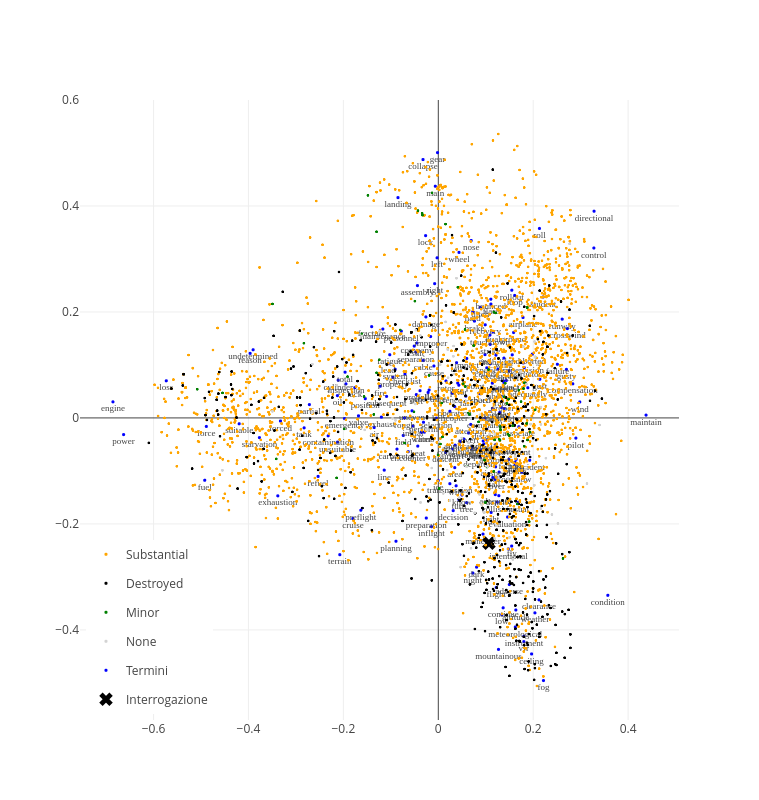

In [150]:
query_trace = go.Scatter(
    x = [-1*qlsn[1]],
    y = [qlsn[2]],
    mode = "markers",
    name = "Interrogazione",
    marker = dict(
        size = 12,
        color = "black",
        symbol = "x"
    )
)

plot_lsa2D_termdoc(
    df["damage_class"],
    -1*dlsn[:,1],
    dlsn[:,2],
    -1*tlsn[:,1],
    tlsn[:,2],
    ord_terms
).update_layout(legend=dict(
    yanchor="bottom",
    y=0.01,
    xanchor="left",
    x=0.01
)).add_trace(query_trace).show()

In [151]:
qclasses = ["Destroyed"]
dls_rows = dls.shape[0]
classes = df["damage_class"]

chisquare_lsa(
    qclasses,
    qterms,
    query_matching_idxs, 
    classes,
    dls_rows
)

Pearson's Chi-squared test with 1 ddof
--------------------------------------

Observed frequencies
+---------------------+-----------------+-------------+
|                     |   not Destroyed |   Destroyed |
|---------------------+-----------------+-------------|
| not adverse_weather |            2415 |         332 |
| adverse_weather     |             332 |         150 |
+---------------------+-----------------+-------------+

Expected frequencies
+---------------------+-----------------+-------------+
|                     |   not Destroyed |   Destroyed |
|---------------------+-----------------+-------------|
| not adverse_weather |        2336.95  |    410.051  |
| adverse_weather     |         410.051 |     71.9492 |
+---------------------+-----------------+-------------+

X-squared: 	116.98962340467432
p-value 	2.8857345092259345e-27


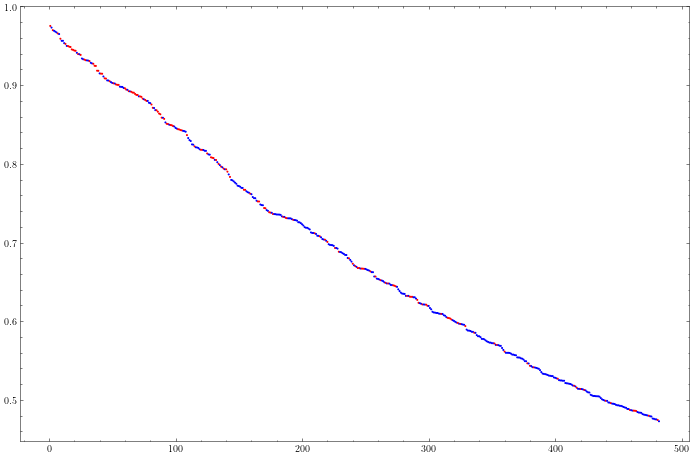

In [152]:
destroyed_idx = np.asarray(df["damage_class"] == "Destroyed")
destroyed_entries = np.asarray(
    [1 if destroyed_idx[idx] == 1 else 0 for idx in query_matching_idxs]
)

plt.figure(figsize=(12, 8))
plt.scatter(
    np.linspace(1, 482, 482),
    sim_scores,
    c = destroyed_entries,
    marker = "o",
    cmap = "bwr",
    s = 1
)
plt.show()

## Costruzione di un'interrogazione articolata

In [157]:
knee = 6
tlsn = norm(tls[:,0:knee], 2, axis = 1)

In [158]:
docs = df.narr_cause
qterms = ["adverse", "weather"]
_, _, _, qls, _, _ = makequery(qterms, tdm, U, s, vocabulary);

docs_ranked1, terms_ranked1, norms1 = \
    get_query_result(
        docs,
        ord_terms,
        dls[:,0:knee],
        tls[:,0:knee],
        qls[0:knee], 
        tlsn,
        high=0.8
    )
docs_matching_query1 = [rank[0] for rank in docs_ranked1]

In [159]:
ranked_terms = [(rank[2], rank[1], norm) for rank, norm in zip(terms_ranked1, norms1)]
ranked_terms.sort(key=lambda y: y[2], reverse=True)
ranked_terms

[(0.8199908158643807, 'condition', 3.2117615854918626),
 (0.9717413436369489, 'weather', 1.9481984097275264),
 (0.9436167770994602, 'instrument', 1.5522192056299544),
 (0.9326408612624346, 'night', 1.3938789962689166),
 (0.9637723791398514, 'meteorological', 1.2162988533627574),
 (0.9291645191481028, 'ceiling', 1.0835294970940692),
 (0.8290146400782389, 'snow', 1.0464340161713983),
 (0.9355617988777334, 'dark', 1.0238275074358427),
 (0.9026718296250141, 'continue', 1.0070405351925207),
 (0.9717324834279831, 'vfr', 0.946162559791531),
 (0.9797430331617991, 'adverse', 0.9108828926919034),
 (0.9470297755971868, 'mountainous', 0.8925661790914144),
 (0.9523551915651138, 'fog', 0.7571045149564712),
 (0.8699464019557852, 'cover', 0.706108255349524),
 (0.8516166319827634, 'light', 0.6374844488993917),
 (0.878298173984005, 'evaluation', 0.5994566598298441)]

In [161]:
qclasses = ["Destroyed"]
dls_rows = dls.shape[0]
classes = df["damage_class"]

chisquare_lsa(
    qclasses,
    qterms,
    docs_matching_query1, 
    classes,
    dls_rows
)

Pearson's Chi-squared test with 1 ddof
--------------------------------------

Observed frequencies
+---------------------+-----------------+-------------+
|                     |   not Destroyed |   Destroyed |
|---------------------+-----------------+-------------|
| not adverse_weather |            2415 |         332 |
| adverse_weather     |             332 |         150 |
+---------------------+-----------------+-------------+

Expected frequencies
+---------------------+-----------------+-------------+
|                     |   not Destroyed |   Destroyed |
|---------------------+-----------------+-------------|
| not adverse_weather |        2336.95  |    410.051  |
| adverse_weather     |         410.051 |     71.9492 |
+---------------------+-----------------+-------------+

X-squared: 	116.98962340467432
p-value 	2.8857345092259345e-27


In [162]:
qterms = ["adverse", "weather", "instrument"]
_, _, _, qls, _, _ = makequery(qterms, tdm, U, s, vocabulary);

docs_ranked2, terms_ranked2, norms2 = \
    get_query_result(
        docs,
        ord_terms,
        dls[:,0:knee],
        tls[:,0:knee],
        qls[0:knee], 
        tlsn,
        high=0.8
    )
docs_matching_query2 = [rank[0] for rank in docs_ranked2]

In [163]:
ranked_terms = [(rank[2], rank[1], norm) for rank, norm in zip(terms_ranked2, norms2)]
ranked_terms.sort(key=lambda y: y[2], reverse=True)
ranked_terms

[(0.9567910605490977, 'weather', 1.9481984097275264),
 (0.9703432522998183, 'instrument', 1.5522192056299544),
 (0.9431031942610328, 'night', 1.3938789962689166),
 (0.9855568354482984, 'meteorological', 1.2162988533627574),
 (0.9609507146032727, 'ceiling', 1.0835294970940692),
 (0.9500959730303234, 'dark', 1.0238275074358427),
 (0.9259378598043291, 'continue', 1.0070405351925207),
 (0.9868928076789402, 'vfr', 0.946162559791531),
 (0.978198405094489, 'adverse', 0.9108828926919034),
 (0.9645823881266132, 'mountainous', 0.8925661790914144),
 (0.9722504416850062, 'fog', 0.7571045149564712),
 (0.8447513496818911, 'cover', 0.706108255349524),
 (0.8517119480956943, 'light', 0.6374844488993917),
 (0.8217671772778079, 'evaluation', 0.5994566598298441)]

In [164]:
get_matching_docs(docs_matching_query1, docs_matching_query2)

447

In [165]:
qclasses = ["Destroyed"]
dls_rows = dls.shape[0]
classes = df["damage_class"]

chisquare_lsa(
    qclasses,
    qterms,
    docs_matching_query2, 
    classes,
    dls_rows
)

Pearson's Chi-squared test with 1 ddof
--------------------------------------

Observed frequencies
+--------------------------------+-----------------+-------------+
|                                |   not Destroyed |   Destroyed |
|--------------------------------+-----------------+-------------|
| not adverse_weather_instrument |            2419 |         328 |
| adverse_weather_instrument     |             328 |         154 |
+--------------------------------+-----------------+-------------+

Expected frequencies
+--------------------------------+-----------------+-------------+
|                                |   not Destroyed |   Destroyed |
|--------------------------------+-----------------+-------------|
| not adverse_weather_instrument |        2336.95  |    410.051  |
| adverse_weather_instrument     |         410.051 |     71.9492 |
+--------------------------------+-----------------+-------------+

X-squared: 	129.28801585041077
p-value 	5.8658165436651474e-30


In [166]:
qterms = ["adverse", "weather", "instrument", "meteorological"]
_, _, _, qls, _, _ = makequery(qterms, tdm, U, s, vocabulary);

docs_ranked3, terms_ranked3, norms3 = \
    get_query_result(
        docs,
        ord_terms,
        dls[:,0:knee],
        tls[:,0:knee],
        qls[0:knee], 
        tlsn,
        high=0.9
    )
docs_matching_query3 = [rank[0] for rank in docs_ranked3]

In [167]:
ranked_terms = [(rank[2], rank[1], norm) for rank, norm in zip(terms_ranked3, norms3)]
ranked_terms.sort(key=lambda y: y[2], reverse=True)
ranked_terms

[(0.9460055495017523, 'weather', 1.9481984097275264),
 (0.9731747058783794, 'instrument', 1.5522192056299544),
 (0.9410550322622876, 'night', 1.3938789962689166),
 (0.9876496001727312, 'meteorological', 1.2162988533627574),
 (0.9652444794196247, 'ceiling', 1.0835294970940692),
 (0.9491010522537346, 'dark', 1.0238275074358427),
 (0.927086560592369, 'continue', 1.0070405351925207),
 (0.986690946604063, 'vfr', 0.946162559791531),
 (0.9719522280451794, 'adverse', 0.9108828926919034),
 (0.9646444748218211, 'mountainous', 0.8925661790914144),
 (0.9725441664979837, 'fog', 0.7571045149564712)]

In [168]:
get_matching_docs(docs_matching_query1, docs_matching_query3)

436

In [169]:
qclasses = ["Destroyed"]
dls_rows = dls.shape[0]
classes = df["damage_class"]

chisquare_lsa(
    qclasses,
    qterms,
    docs_matching_query3, 
    classes,
    dls_rows
)

Pearson's Chi-squared test with 1 ddof
--------------------------------------

Observed frequencies
+-----------------------------------------------+-----------------+-------------+
|                                               |   not Destroyed |   Destroyed |
|-----------------------------------------------+-----------------+-------------|
| not adverse_weather_instrument_meteorological |            2423 |         324 |
| adverse_weather_instrument_meteorological     |             324 |         158 |
+-----------------------------------------------+-----------------+-------------+

Expected frequencies
+-----------------------------------------------+-----------------+-------------+
|                                               |   not Destroyed |   Destroyed |
|-----------------------------------------------+-----------------+-------------|
| not adverse_weather_instrument_meteorological |        2336.95  |    410.051  |
| adverse_weather_instrument_meteorological     |         

In [170]:
qterms = ["adverse", "weather", "instrument", "meteorological", "continue"]
_, _, _, qls, _, _ = makequery(qterms, tdm, U, s, vocabulary);

docs_ranked4, terms_ranked4, norms4 = \
    get_query_result(
        docs,
        ord_terms,
        dls[:,0:knee],
        tls[:,0:knee],
        qls[0:knee], 
        tlsn,
        high=0.9
    )
docs_matching_query4 = [rank[0] for rank in docs_ranked4]

In [171]:
ranked_terms = [(rank[2], rank[1], norm) for rank, norm in zip(terms_ranked3, norms3)]
ranked_terms.sort(key=lambda y: y[2], reverse=True)
ranked_terms

[(0.9460055495017523, 'weather', 1.9481984097275264),
 (0.9731747058783794, 'instrument', 1.5522192056299544),
 (0.9410550322622876, 'night', 1.3938789962689166),
 (0.9876496001727312, 'meteorological', 1.2162988533627574),
 (0.9652444794196247, 'ceiling', 1.0835294970940692),
 (0.9491010522537346, 'dark', 1.0238275074358427),
 (0.927086560592369, 'continue', 1.0070405351925207),
 (0.986690946604063, 'vfr', 0.946162559791531),
 (0.9719522280451794, 'adverse', 0.9108828926919034),
 (0.9646444748218211, 'mountainous', 0.8925661790914144),
 (0.9725441664979837, 'fog', 0.7571045149564712)]

In [172]:
get_matching_docs(docs_matching_query1, docs_matching_query4)

426

In [173]:
qclasses = ["Destroyed"]
dls_rows = dls.shape[0]
classes = df["damage_class"]

chisquare_lsa(
    qclasses,
    qterms,
    docs_matching_query4, 
    classes,
    dls_rows
)

Pearson's Chi-squared test with 1 ddof
--------------------------------------

Observed frequencies
+--------------------------------------------------------+-----------------+-------------+
|                                                        |   not Destroyed |   Destroyed |
|--------------------------------------------------------+-----------------+-------------|
| not adverse_weather_instrument_meteorological_continue |            2425 |         322 |
| adverse_weather_instrument_meteorological_continue     |             322 |         160 |
+--------------------------------------------------------+-----------------+-------------+

Expected frequencies
+--------------------------------------------------------+-----------------+-------------+
|                                                        |   not Destroyed |   Destroyed |
|--------------------------------------------------------+-----------------+-------------|
| not adverse_weather_instrument_meteorological_continue | 

In [174]:
qterms = ["adverse", "weather", "instrument", "meteorological", "continue", "vfr"]
_, _, _, qls, _, _ = makequery(qterms, tdm, U, s, vocabulary);

docs_ranked5, terms_ranked5, norms5 = \
    get_query_result(
        docs,
        ord_terms,
        dls[:,0:knee],
        tls[:,0:knee],
        qls[0:knee], 
        tlsn,
        high=0.9
    )
docs_matching_query5 = [rank[0] for rank in docs_ranked5]

In [175]:
get_matching_docs(docs_matching_query1, docs_matching_query5)

424

In [177]:
doc_classes = ["Destroyed"]
qterms = ["adverse", "weather", "instrument", "meteorological", "continue", "vfr"]
dls_rows = dls.shape[0]
classes = df["damage_class"]

chisquare_lsa(
    qclasses,
    qterms,
    docs_matching_query5, 
    classes,
    dls_rows
)

Pearson's Chi-squared test with 1 ddof
--------------------------------------

Observed frequencies
+------------------------------------------------------------+-----------------+-------------+
|                                                            |   not Destroyed |   Destroyed |
|------------------------------------------------------------+-----------------+-------------|
| not adverse_weather_instrument_meteorological_continue_vfr |            2426 |         321 |
| adverse_weather_instrument_meteorological_continue_vfr     |             321 |         161 |
+------------------------------------------------------------+-----------------+-------------+

Expected frequencies
+------------------------------------------------------------+-----------------+-------------+
|                                                            |   not Destroyed |   Destroyed |
|------------------------------------------------------------+-----------------+-------------|
| not adverse_weather_i

## Costruzione automatica di un'interrogazione

Si minimizza il p-value e si prosegue fino a quando il p-value dell'interrogazione costruita fino a quel momento non scende sotto un certo valore di tolleranza `tol` oppure se la lista di termini tra cui scegliere per espandere l'interrogazione si esaurisce.

In [184]:
knee = 6
r = 482
tol = 1e-05
tlsn = norm(tls[:,0:knee], 2, axis = 1)
docs = df.narr_cause
qclasses = ["Destroyed"]
dls_rows = dls.shape[0]
classes = df["damage_class"]
qterms = ["adverse"]
_, _, _, qls, _, _ = makequery(qterms, tdm, U, s, vocabulary);

docs_ranked, terms_ranked, norms = \
    get_query_result(
        docs,
        ord_terms,
        dls[:,0:knee],
        tls[:,0:knee],
        qls[0:knee], 
        tlsn,
        high=0.9,
        r=r
    )
docs_matching_query = [rank[0] for rank in docs_ranked]

chi2, p = chisquare_lsa(
    qclasses,
    qterms,
    docs_matching_query, 
    classes,
    dls_rows,
    quiet=True
)
current_p_value = p
current_terms_ranked = terms_ranked
exit = False

while current_p_value < tol and exit == False:
    terms_list = []
    for term in current_terms_ranked:

        if term[1] not in qterms:
            tmpq = qterms + [term[1]]
            _, _, _, qls, _, _ = makequery(tmpq, tdm, U, s, vocabulary);

            docs_ranked, terms_ranked, norms = \
            get_query_result(
                docs,
                ord_terms,
                dls[:,0:knee],
                tls[:,0:knee],
                qls[0:knee], 
                tlsn,
                high=0.8,
                r=r
            )
            docs_matching_query = [rank[0] for rank in docs_ranked]

            chi2, p = chisquare_lsa(
                qclasses,
                tmpq,
                docs_matching_query, 
                classes,
                dls_rows,
                quiet=True
            )
            terms_list.append((term[1], p, terms_ranked))

    if len(terms_list) == 0:
        exit = True
    else:    
        terms_list.sort(key=lambda y: y[1])
        print(terms_list[0][0] + " p: " + str(terms_list[0][1]))
        qterms.append(terms_list[0][0])
        current_p_value = terms_list[0][1]
        current_terms_ranked = terms_list[0][2]
        
qterms

instrument p: 2.87628140044995e-37
ceiling p: 7.897307089175809e-39
continue p: 3.1135255786433093e-41
know p: 3.1135255786433093e-41
fog p: 3.1135255786433093e-41
mountainous p: 3.1135255786433093e-41
meteorological p: 2.0088876461504553e-40
dark p: 1.2716400574568628e-39
night p: 1.2716400574568628e-39
vfr p: 7.897307089175809e-39
light p: 2.87628140044995e-37
cover p: 5.478756017747545e-35
weather p: 5.478756017747545e-35


['adverse',
 'instrument',
 'ceiling',
 'continue',
 'know',
 'fog',
 'mountainous',
 'meteorological',
 'dark',
 'night',
 'vfr',
 'light',
 'cover',
 'weather']